# <p style="text-align: center;">Multiclass Image Classification Using CNN</p>

### **1. Import the Required Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

### **2. Load the Image Training and Validation Datasets**

#### **i. Get the Image Dataset Paths**

In [2]:
train_dataset_path = '/kaggle/input/intel-image-classification/seg_train/seg_train/'
validation_dataset_path = '/kaggle/input/intel-image-classification/seg_test/seg_test/'

#### **ii. Load Image Datasets and Apply Augmentations**

Since the images present in the datasets are 150x150px in size, the image height and width are taken as 150, 150 respectively. The batch size value can be changed if required.

In [3]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

Loading the training dataset and applying augmentations on it.

In [4]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 14034 images belonging to 6 classes.


Loading the validation dataset.

In [5]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 3000 images belonging to 6 classes.


#### **iii. Get the Label Mappings**

In [6]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


### **3. Plotting Sample Training Images**

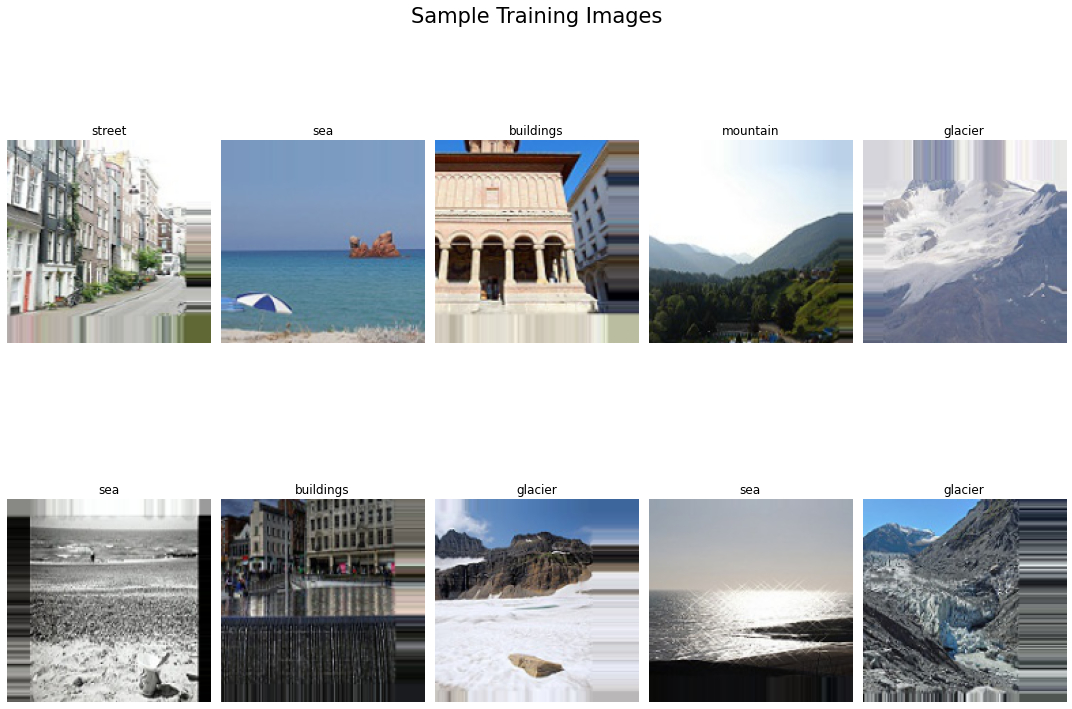

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()

### **4. Training a CNN Model**

Since the training dataset is ready let's create a simple CNN Model to train on the image datasets

#### **i. Create a CNN Model**

In [8]:
def create_model():
    model = Sequential([
        Conv2D(filters=128, kernel_size=(5, 5), padding='valid', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),
        
        Flatten(),
        
        Dense(units=256, activation='relu'),
        Dropout(0.5),
        Dense(units=6, activation='softmax')
    ])
    
    return model

In [9]:
cnn_model = create_model()

In [10]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 146, 146, 128)     9728      
_________________________________________________________________
activation (Activation)      (None, 146, 146, 128)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 73, 73, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 64)        73792     
_________________________________________________________________
activation_1 (Activation)    (None, 71, 71, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 64)        0

#### **ii. Defining Callbacks**

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)

#### **a. Reduce Learning Rate on Plateau**

Is used to reduce the learning rate when a metric has stopped improving.

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

#### **iii. Defining the Optimizer**

In [12]:
optimizer = Adam(learning_rate=0.001)

#### **iv. Compile the Model**

In [13]:
cnn_model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])

#### **v. Training the Model**

In [14]:
history = cnn_model.fit(train_generator, epochs=50, validation_data=validation_generator,
                       verbose=2,
                       callbacks=[reduce_lr])

Epoch 1/50
439/439 - 170s - loss: 2.0531 - accuracy: 0.4887 - val_loss: 1.1131 - val_accuracy: 0.6020
Epoch 2/50
439/439 - 88s - loss: 1.0870 - accuracy: 0.6045 - val_loss: 0.8851 - val_accuracy: 0.6400
Epoch 3/50
439/439 - 89s - loss: 0.9373 - accuracy: 0.6556 - val_loss: 0.7214 - val_accuracy: 0.7283
Epoch 4/50
439/439 - 99s - loss: 0.8699 - accuracy: 0.6784 - val_loss: 0.7573 - val_accuracy: 0.7257
Epoch 5/50
439/439 - 87s - loss: 0.8192 - accuracy: 0.7001 - val_loss: 0.7654 - val_accuracy: 0.7347
Epoch 6/50
439/439 - 152s - loss: 0.7752 - accuracy: 0.7195 - val_loss: 0.6537 - val_accuracy: 0.7767
Epoch 7/50
439/439 - 157s - loss: 0.7282 - accuracy: 0.7400 - val_loss: 0.6885 - val_accuracy: 0.7533
Epoch 8/50
439/439 - 106s - loss: 0.7118 - accuracy: 0.7467 - val_loss: 2.1238 - val_accuracy: 0.4890
Epoch 9/50
439/439 - 104s - loss: 0.6742 - accuracy: 0.7604 - val_loss: 1.0558 - val_accuracy: 0.6147
Epoch 10/50
439/439 - 108s - loss: 0.6441 - accuracy: 0.7749 - val_loss: 0.5804 - val_

### **5. Plotting the Model Metrics**

#### **i. Plotting training and validation accuracy, loss and learning rate**

In [15]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

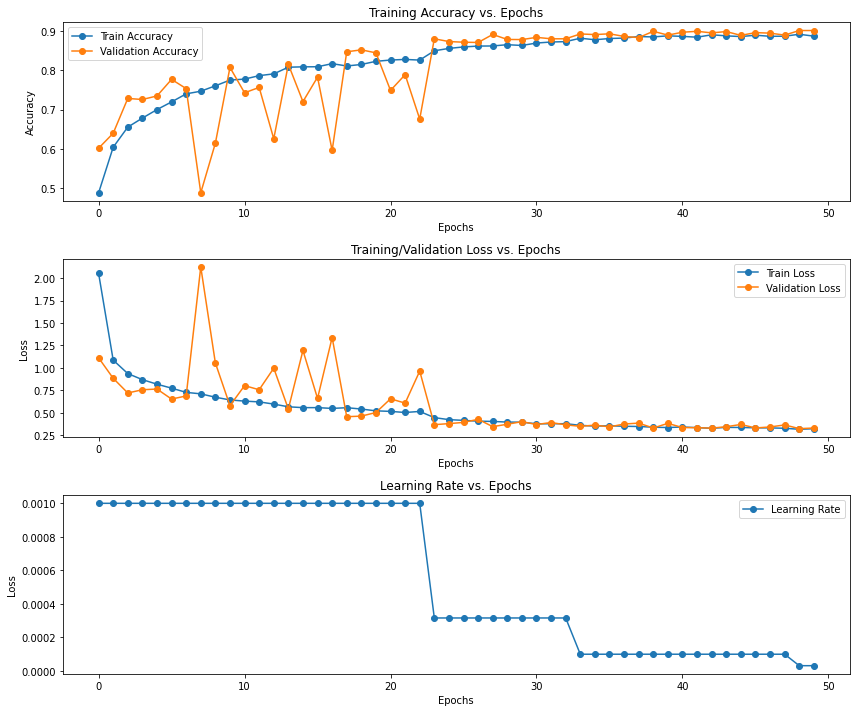

In [29]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

### **6. Testing the Model on Test Set**

Testing the model on the validation dataset because a seperate dataset for testing is not available.

In [30]:
test_dataset = '/kaggle/input/intel-image-classification/seg_test/seg_test/'

In [31]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 3000 images belonging to 6 classes.


### **7. Model Prediction on the Test Dataset**

In [32]:
predictions = cnn_model.predict(test_generator)

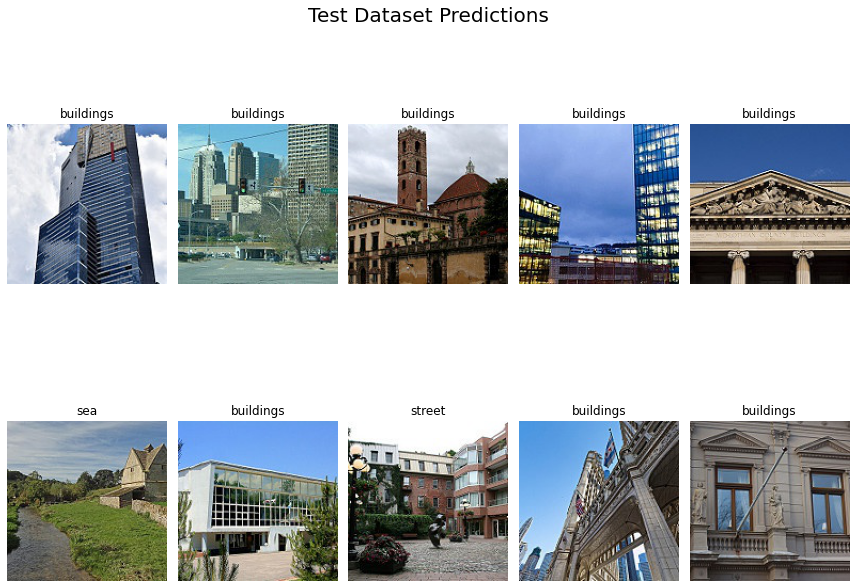

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [34]:
test_loss, test_accuracy = cnn_model.evaluate(test_generator, batch_size=BATCH_SIZE)

94/94 [==============================] - 5s 50ms/step - loss: 0.3317 - accuracy: 0.9007


In [35]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.3316926956176758
Test Accuracy: 0.9006666541099548


### **8. Plotting the Classification Metrics**

### **i. Confusion Matrix**

In [36]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

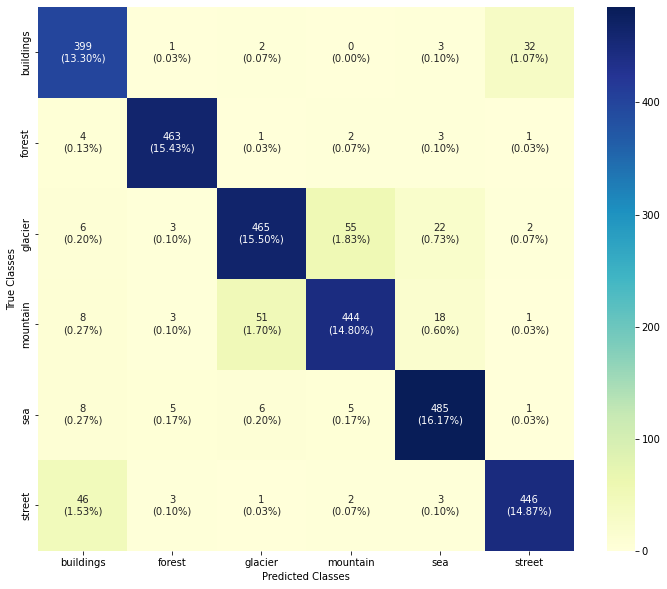

In [37]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(6, 6)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [38]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

   buildings       0.85      0.91      0.88       437
      forest       0.97      0.98      0.97       474
     glacier       0.88      0.84      0.86       553
    mountain       0.87      0.85      0.86       525
         sea       0.91      0.95      0.93       510
      street       0.92      0.89      0.91       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000

